### Введение

В своей классической работе о переходности, Хоппер и Томпсон (1980: 252) выделают следующие параметры, характерные для типично переходной и типично непереходной ситуаций.

| criterion | high transitivity | low transitivity |
|-----------|-------------------|------------------|
| a. Participants | 2+ | 1 |
| b. Kinesis | action | non-action |
| c. Aspect | telic | atelic |
| d. Punctuality | punctual | non-punctual |
| e. Volitionality | volitional | non-volitional |
| f. Affirmation | affirmative | negative |
| g. Mode | realis | irrealis |
| h. Agency | A high in potency | A low in potency |
| i. Affectedness of O | O totally affected | O not affected |
| j. Individuation of O | O highly individuated | O non-individuated |

В данной работе я хочу посмотреть, насколько переходные и непереходные глаголы в "Приглашении на казнь" близки или далеки от своего прототипа. Для простоты я ограничусь следующими параметрами:
* переходность глагола
* вид глагола (совершенный будет считаться как telic, несовершенный как atelic)
* одушевлённость подлежащего
* одушевлённость дополнения (если имеется)
* число дополнения (если имеется)

### 1. Создание базы данных

База данных будет иметь следующую архитектуру:
1. таблица с глаголами и их характеристиками
2. таблица с подлежащими непереходных глаголов и их характеристиками
3. таблица с подлежащими переходных глаголов и их характеристиками
4. таблица с дополнениями переходных глаголов и их характеристиками

In [1]:
import nltk

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NewUser\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\NewUser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
file = open('Приглашение_на_казнь.txt', 'r', encoding='utf-8')
cincinnat = file.read()
file.close()

In [4]:
death_sentence = nltk.sent_tokenize(cincinnat)
death_sentence[:10]

['Владимир Набоков.',
 'Приглашение на казнь\n\n\n\nComme un fou se croit Dieu\nnous nous croyons mortels.',
 '/Delalande.',
 'Discours sur les ombres/[*]\n\n------------------------------------------------\n[*] Подобно тому как глупец полагает себя богом,\nмы считаем, что мы смертны.',
 '/Делаланд.',
 '"Разговоры теней"/ (франц.).',
 '----------------------------\n\n\nI\n\n\n     Сообразно  с  законом,  Цинциннату  Ц.  объявили  смертный\nприговор  шепотом.',
 'Все  встали,  обмениваясь  улыбками.',
 'Седой\nсудья,   припав  к   его  уху,   подышав,   сообщив,   медленно\nотодвинулся,   как  будто  отлипал.',
 'Засим  Цинцинната  отвезли\nобратно в  крепость.']

In [6]:
import natasha

In [7]:
emb = natasha.NewsEmbedding()
segmenter = natasha.Segmenter()
morph_vocab = natasha.MorphVocab()
morph_tagger = natasha.NewsMorphTagger(emb)
syntax_parser = natasha.NewsSyntaxParser(emb)

In [8]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [1]:
import sqlite3

In [11]:
conn = sqlite3.connect('example.db')
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS verbs")
c.execute("DROP TABLE IF EXISTS intrans_subjects")
c.execute("DROP TABLE IF EXISTS trans_subjects")
c.execute("DROP TABLE IF EXISTS objects")
c.execute('PRAGMA encoding="UTF-8"')
c.execute("CREATE TABLE IF NOT EXISTS verbs(id INTEGER PRIMARY KEY, form text, transitivity text, aspect text)")
c.execute("CREATE TABLE IF NOT EXISTS intrans_subjects(id integer not null references verbs(id), form text, pos text, animacy text)")
c.execute("CREATE TABLE IF NOT EXISTS trans_subjects(id integer not null references verbs(id), form text, pos text, animacy text)")
c.execute("CREATE TABLE IF NOT EXISTS objects(id integer not null references verbs(id), form text, pos text, animacy text, number text)")
conn.commit()

In [12]:
def add_to_db(pred, t, a, subj, s_pos, s_an, obj, o_pos, o_an, o_num, i):
    c.execute('INSERT INTO verbs (id, form, transitivity, aspect) VALUES (?, ?, ?, ?)', (i, pred, t, a))
    if t == 'tran':
        c.execute('INSERT INTO trans_subjects (id, form, pos, animacy) VALUES (?, ?, ?, ?)', (i, subj, s_pos, s_an))
        c.execute('INSERT INTO objects (id, form, pos, animacy, number) VALUES (?, ?, ?, ?, ?)', (i, obj, o_pos, o_an, o_num))
    else:
        c.execute('INSERT INTO intrans_subjects (id, form, pos, animacy) VALUES (?, ?, ?, ?)', (i, subj, s_pos, s_an))
    conn.commit()

In [13]:
i = 0
for s in death_sentence:
    doc = natasha.Doc(s)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    dic = {_.text: _.rel for _ in doc.tokens}
    synt = dict((v,k) for k,v in dic.items())
    doc.tag_morph(morph_tagger)
    pos = {_.text: _.pos for _ in doc.tokens}
    feats = {_.text: _.feats for _ in doc.tokens}
    pred = 0
    t = 0
    a = 0
    subj = 0
    s_pos = 0
    s_an = 0
    obj = 0
    o_pos = 0
    o_an = 0
    o_num = 0
    try:
        pred = synt['root']
        if pos[pred] == 'VERB':
            m = morph.parse(pred)[0]
            t = m.tag.transitivity
            a = feats[pred]['Aspect']
            if t == 'tran':
                try:
                    obj = synt['obj']
                    o_pos = pos[obj]
                    o_an = feats[obj]['Animacy']
                    o_num = feats[obj]['Number']
                except:
                    pass
            try:
                subj = synt['nsubj']
                s_pos = pos[subj]
                s_an = feats[subj]['Animacy']
            except:
                pass
            i += 1
            add_to_db(pred, t, a, subj, s_pos, s_an, obj, o_pos, o_an, o_num, i)
    except:
        pass

In [14]:
conn.commit()
conn.close()

In [2]:
conn2 = sqlite3.connect('example.db')
c2 = conn2.cursor()
c2.execute('SELECT * FROM verbs')
print(c2.fetchmany(5))

[(1, 'считаем', 'tran', 'Imp'), (2, 'объявили', 'tran', 'Perf'), (3, 'встали', 'intr', 'Perf'), (4, 'отодвинулся', 'intr', 'Imp'), (5, 'отвезли', 'tran', 'Perf')]


In [3]:
import pandas as pd

In [4]:
verbs_df = pd.read_sql_query('SELECT * from verbs', conn2)

In [5]:
print(verbs_df.head())

   id         form transitivity aspect
0   1      считаем         tran    Imp
1   2     объявили         tran   Perf
2   3       встали         intr   Perf
3   4  отодвинулся         intr    Imp
4   5      отвезли         tran   Perf


In [6]:
tr_subj_df = pd.read_sql_query('SELECT * from trans_subjects', conn2)
print(tr_subj_df.head())

   id        form    pos animacy
0   1          мы   PRON       0
1   2  Цинциннату  PROPN    Anim
2   5       Засим  PROPN    Anim
3   7       Дверь   NOUN    Inan
4   9         все   PRON    Anim


In [7]:
intr_subj_df = pd.read_sql_query('SELECT * from intrans_subjects', conn2)
print(intr_subj_df.head())

   id     form   pos animacy
0   3      Все  PRON    Anim
1   4    судья  NOUN    Anim
2   6   Дорога  NOUN    Inan
3   8  адвокат  NOUN    Anim
4  10      все  PRON    Inan


In [8]:
obj_df = pd.read_sql_query('SELECT * from objects', conn2)
print(obj_df.head())

   id      form   pos animacy number
0   1      себя  PRON       0      0
1   2  приговор  NOUN    Inan   Sing
2   5         0     0       0      0
3   7         0     0       0      0
4   9         0     0       0      0


In [9]:
conn2.close()

### 2. Вид

Хоппер (1979: 219) в своей работе про foregrounding in discourse пишет, что в русском языке совершенный вид ассоциирован с foregrounding'ом, а несовершенный - с backgrounding'ом. Выше с помощью библиотеки Natasha я сохраняла в базу данных в качестве предикатов только те лексемы, которые в синтаксическом разборе были помечены как 'root'. Этим тегом помечаются только сказуемые **главной** клаузы. Фоновая информация обычно содержится в подчинённых предложениях. Тем самым, мы можем предположить, что в наших данных глаголов совершенного вида больше, чем несовершенного. Построим график, чтобы это проверить.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='aspect', ylabel='count'>

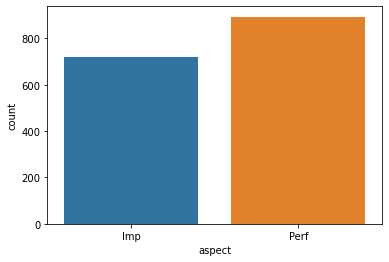

In [24]:
sns.countplot(x = "aspect", data = verbs_df)

На графике видно, что глаголов совершенного вида в выборке действительно больше, чем глаголов несовершенного. Проверим, является ли эта разница статистически значимой.

In [25]:
verbs_df['aspect'].value_counts()

Perf    893
Imp     718
Name: aspect, dtype: int64

In [23]:
from statsmodels.stats.proportion import proportions_ztest

In [34]:
proportions_ztest(893, 1611, value = 0.5, alternative = 'larger')

(4.385992368340316, 5.772908466140036e-06)

Статистически вероятность наткнуться в данных на глагол совершенного вида значимо отлична от 50% в большую сторону. Наблюдение Хоппера подтверждается нашими данными.

Теперь посмотрим на распределение видов глаголов в зависимости от их переходности.

<AxesSubplot:xlabel='count', ylabel='transitivity'>

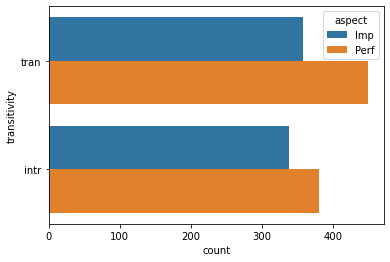

In [41]:
sns.countplot(data=verbs_df, y='transitivity', hue='aspect')

На графике видно, что разница между совершенным и несовершенным видом для переходных глаголов больше, чем для непереходных. Проверим это статистически.

In [48]:
ch = pd.crosstab(verbs_df['transitivity'], verbs_df['aspect'])

In [45]:
from scipy.stats import chi2_contingency

In [47]:
stat, p, dof, expected = chi2_contingency(ch)
p

0.32414403165834876

p-value больше 0.05, поэтому у нас нет оснований считать, что переменные зависимы друг от друга. Тем самым, переходность и вид не влияют друг на друга.

### 3. Одушевлённость подлежащего

По Хопперу и Томпсон, переходность ассоциирована с более активным деятелем, а непереходность - с менее активным. Здесь мы упрощаем активность подлежащего до его одушевлённости. Посмотрим на графике, есть ли разница в одушевлённости между переходными и непереходными подлежащими.

In [13]:
tr_subj_df['transitivity'] = 'tran'
intr_subj_df['transitivity'] = 'intr'
subjects = pd.concat([tr_subj_df, intr_subj_df])

In [16]:
subjects.groupby('animacy').count()

,id,form,pos,transitivity
animacy,,,,
0,831,831,831,831
Anim,437,437,437,437
Inan,343,343,343,343


Видно, что у половины подлежащих неопределена одушевлённость. Посмотрим, для слов каких частей речи одушевлённость не определена.

In [20]:
subjects[subjects['animacy'] == '0']['pos'].value_counts()

PRON     490
0        271
DET       18
ADJ       15
VERB      12
ADV        8
SCONJ      8
NUM        7
X          1
PART       1
Name: pos, dtype: int64

Самые большие группы - это подлежащие-местоимения и подлежащие "без части речи". Посмотрим внимательнее на то, какие слова встречаются в этих группах частей речи и в других.

In [21]:
subjects[subjects['pos'] == 'PRON']['form'].value_counts()

он            106
я              99
она            38
Я              37
Он             36
вы             34
это            22
все            19
который        16
Она            15
они            14
ты             13
Вы             13
мы             12
которая         8
Все             6
Мы              6
Это             5
что             5
кто             5
которые         5
то              4
что-то          4
кто-то          4
никто           3
ничего          3
оно             3
Кто             2
Ты              2
Ничего          2
Что             2
того            1
ничто           1
некто           1
Что-нибудь      1
Оно             1
чему-то         1
Кто-нибудь      1
тебя            1
Что-то          1
То              1
Кто-то          1
себя            1
Name: form, dtype: int64

Местоимения третьего лица и неопределённые местоимения сложно однозначно отнести к одушевлённым или неодушевлённым в общем случае. Однако местоимения 1-2 лица можно с уверенностью считать одушевлёнными.

In [32]:
subjects['form'] = subjects['form'].str.lower()
subjects.loc[subjects['form'] == 'я', 'animacy'] = 'Anim'
subjects.loc[subjects['form'] == 'мы', 'animacy'] = 'Anim'
subjects.loc[subjects['form'] == 'ты', 'animacy'] = 'Anim'
subjects.loc[subjects['form'] == 'вы', 'animacy'] = 'Anim'
subjects.head()

,id,form,pos,animacy,transitivity
0,1,мы,PRON,Anim,tran
1,2,цинциннату,PROPN,Anim,tran
2,5,засим,PROPN,Anim,tran
3,7,дверь,NOUN,Inan,tran
4,9,все,PRON,Anim,tran


In [33]:
subjects[subjects['pos'] == '0']['form'].value_counts()

0    271
Name: form, dtype: int64

Эта группа - это отсутствующие подлежащие. Пока что их просто выкинем. Также выкинем все остальные подлежащие с неопределённой одушевлённостью.

In [43]:
not_null_subjects = subjects[subjects.form != '0']
not_null_subjects = not_null_subjects[not_null_subjects.animacy != '0']

<AxesSubplot:xlabel='count', ylabel='transitivity'>

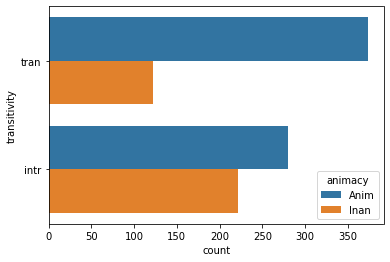

In [44]:
sns.countplot(data=not_null_subjects, y='transitivity', hue='animacy')

По графику видно, что подлежащии переходных глаголов с большей вероятностью будут одушевлёнными, чем непереходных. Проверим, подстверждается ли это статистически.

In [47]:
ch = pd.crosstab(not_null_subjects['transitivity'], not_null_subjects['animacy'])
stat, p, dof, expected = chi2_contingency(ch)
p

1.5801830950999775e-10

p-value достаточно маленькое, чтобы можно было отвергнуть гипотезу о независимости одушевлённости подлежащего от переходности глагола.

Теперь посмотрим на распределение нулевых (невыраженных) подлежащих при непереходных и переходных глаголах.

<AxesSubplot:xlabel='count', ylabel='transitivity'>

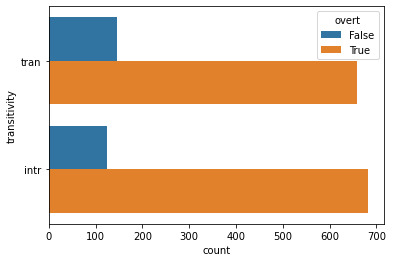

In [54]:
subjects['overt'] = subjects['form'] != '0'
sns.countplot(data=subjects, y='transitivity', hue='overt')

Распределение невыраженных подлежащих примерно одинаковое для глаголов разной переходности. Это тоже можно статистически проверить, но я не буду.

### 4. Одушевлённость дополнения

Согласно Хопперу и Томпсон, в типично переходной ситуации объект действия должен быть highly individuated. Это конечно напрямую не связано с одушевлённостью, но предположим, что одушевлённые объекты более индивидуализированы, чем неодушевлённые, и посмотрим, подтверждается ли это данными.

In [11]:
obj_df[obj_df['animacy'] == '0']['pos'].value_counts()

0        234
PRON      92
VERB      10
ADJ        8
DET        5
ADV        4
PART       4
SCONJ      4
NUM        2
ADP        1
Name: pos, dtype: int64

In [13]:
obj_df[obj_df['pos'] == 'PRON']['form'].value_counts()

его           23
вас           16
ее            14
себя          11
ничего        11
меня           9
тебя           7
все            5
что            4
их             4
Что            4
друг           4
это            4
которые        3
что-нибудь     2
нас            2
Его            2
этого          2
то             2
что-то         2
кого           1
Нас            1
Это            1
Все            1
которую        1
Ее             1
Ничего         1
Их             1
Меня           1
Name: form, dtype: int64

In [15]:
obj_df['form'] = obj_df['form'].str.lower()
obj_df.loc[obj_df['form'] == 'меня', 'animacy'] = 'Anim'
obj_df.loc[obj_df['form'] == 'тебя', 'animacy'] = 'Anim'
obj_df.loc[obj_df['form'] == 'нас', 'animacy'] = 'Anim'
obj_df.loc[obj_df['form'] == 'вас', 'animacy'] = 'Anim'
obj_df.loc[obj_df['form'] == 'себя', 'animacy'] = 'Anim'
obj_df.loc[obj_df['form'] == 'ничего', 'animacy'] = 'Inan'
obj_df.loc[obj_df['form'] == 'что-нибудь', 'animacy'] = 'Inan'
obj_df.loc[obj_df['form'] == 'что-то', 'animacy'] = 'Inan'
obj_df.head()

,id,form,pos,animacy,number
0,1,себя,PRON,Anim,0
1,2,приговор,NOUN,Inan,Sing
2,5,0,0,0,0
3,7,0,0,0,0
4,9,0,0,0,0


In [17]:
not_null_objects = obj_df[obj_df.animacy != '0']
not_null_objects.head()

,id,form,pos,animacy,number
0,1,себя,PRON,Anim,0
1,2,приговор,NOUN,Inan,Sing
5,12,дрожь,NOUN,Inan,Sing
7,15,финал,NOUN,Inan,Sing
8,16,холодок,NOUN,Inan,Sing


<AxesSubplot:xlabel='animacy', ylabel='count'>

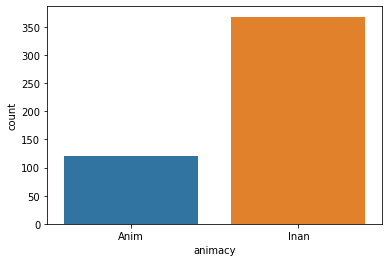

In [20]:
sns.countplot(x = "animacy", data = not_null_objects)

In [22]:
not_null_objects['animacy'].value_counts()

Inan    368
Anim    120
Name: animacy, dtype: int64

In [24]:
proportions_ztest(368, 488, value = 0.5, alternative = 'larger')

(13.035180935797763, 3.859185169635414e-39)

Дополнения в Приглашении на казнь статистически значимо чаще неодушевлённые, чем одушевлённые. Это либо говорит о том, что большинство конструкций с переходными глаголами у Набокова слабопереходные, либо о том, что одушевлённость - не лучший критерий для определения индивидуализированности дополнения.

### 5. Число дополнения

Теперь проверим число дополнений. Наши ожидания, основанные на Хоппере и Томпсон, такие: дополнений в единственном числе будет больше, чем дополнений во множественном числе.

In [25]:
obj_df[obj_df['number'] == '0']['pos'].value_counts()

0        234
PRON      92
VERB      10
ADJ        8
DET        5
ADV        4
PART       4
SCONJ      4
NUM        3
ADP        1
Name: pos, dtype: int64

In [26]:
obj_df[obj_df['pos'] == 'PRON']['form'].value_counts()

его           25
вас           16
ее            15
ничего        12
себя          11
меня          10
что            8
тебя           7
все            6
их             5
это            5
друг           4
которые        3
нас            3
этого          2
что-то         2
что-нибудь     2
то             2
которую        1
кого           1
Name: form, dtype: int64

In [28]:
obj_df['form'] = obj_df['form'].str.lower()
obj_df.loc[obj_df['form'] == 'его', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'вас', 'number'] = 'Plur'
obj_df.loc[obj_df['form'] == 'ее', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'меня', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'тебя', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'их', 'number'] = 'Plur'
obj_df.loc[obj_df['form'] == 'нас', 'number'] = 'Plur'
obj_df.head()

,id,form,pos,animacy,number
0,1,себя,PRON,Anim,0
1,2,приговор,NOUN,Inan,Sing
2,5,0,0,0,0
3,7,0,0,0,0
4,9,0,0,0,0


In [29]:
obj_df[obj_df['pos'] == 'ADJ']['form'].value_counts()

маленькую      1
следующее      1
остальные      1
новую          1
толстый        1
маслянистым    1
прошептала     1
часовой        1
другую         1
маленьких      1
желваками      1
второго        1
Name: form, dtype: int64

In [30]:
obj_df.loc[obj_df['form'] == 'маленькую', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'остальные', 'number'] = 'Plur'
obj_df.loc[obj_df['form'] == 'следующее', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'новую', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'толстый', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'часовой', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'другую', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'маленьких', 'number'] = 'Plur'
obj_df.loc[obj_df['form'] == 'второго', 'number'] = 'Sing'
obj_df.head()

,id,form,pos,animacy,number
0,1,себя,PRON,Anim,0
1,2,приговор,NOUN,Inan,Sing
2,5,0,0,0,0
3,7,0,0,0,0
4,9,0,0,0,0


In [31]:
obj_df[obj_df['pos'] == 'DET']['form'].value_counts()

ту        1
те        1
его       1
мой       1
своего    1
свое      1
Name: form, dtype: int64

In [32]:
obj_df.loc[obj_df['form'] == 'ту', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'те', 'number'] = 'Plur'
obj_df.loc[obj_df['form'] == 'мой', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'своего', 'number'] = 'Sing'
obj_df.loc[obj_df['form'] == 'свое', 'number'] = 'Sing'
obj_df.head()

,id,form,pos,animacy,number
0,1,себя,PRON,Anim,0
1,2,приговор,NOUN,Inan,Sing
2,5,0,0,0,0
3,7,0,0,0,0
4,9,0,0,0,0


In [35]:
not_null_objects = obj_df[obj_df.number != '0']
not_null_objects.head()

,id,form,pos,animacy,number
1,2,приговор,NOUN,Inan,Sing
5,12,дрожь,NOUN,Inan,Sing
7,15,финал,NOUN,Inan,Sing
8,16,холодок,NOUN,Inan,Sing
10,18,горизонт,NOUN,Inan,Sing


<AxesSubplot:xlabel='number', ylabel='count'>

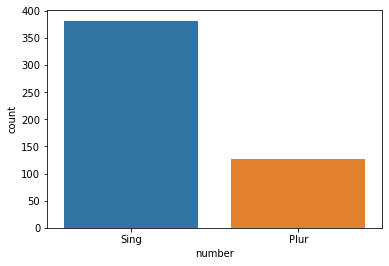

In [36]:
sns.countplot(x = "number", data = not_null_objects)

In [37]:
not_null_objects['number'].value_counts()

Sing    382
Plur    127
Name: number, dtype: int64

In [38]:
proportions_ztest(382, 509, value = 0.5, alternative = 'larger')

(13.059770165519318, 2.7948141531588083e-39)

Наши ожидания оправдались.

### Заключение

| критерий | соответствие Хопперу и Томпсон |
|----------|--------------------------------|
| вид глагола | нет |
| одушевлённость подлежащего | да |
| одушевлённость дополнения | нет |
| число дополнения | да |

#### Идея для финального проекта

Я бы хотела сделать что-то связанное с порядковыми числительными: возможно, выкачать из нкря сколько-то примеров, в которых есть порядковые числительные, разметить их в зависимости от семантики числительного в данном случае. Но это звучит как 30% автоматической работы и 70% работы руками, что, наверное, не очень подходит. Других идей у меня пока нет, если вы подскажете, как можно доработать эту, буду благодарна.